## Instructions

In this exercise, we will practice Natural Language Processing by performing classification on book texts.

We will train a model on a corpus consisting of a handful of books. Then for a given passage of text, we will use the model to predict which book that text is most likely to come from.

Many steps have been done for you, but there are ten "Tasks" you will need to complete along the way.
  



## Setup

In [126]:
%%capture
!pip install gutenbergpy

In [127]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [128]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Loading


Here is a helper function to load book text from [Project Gutenberg](https://gutenberg.org/browse/scores/top):

In [129]:
from gutenbergpy.textget import get_text_by_id, strip_headers
import re


def get_book(book_id=2701):
    """Fetches the text of a book given its gutenberg identifier.

        For a list of books and identifiers, see: https://gutenberg.org/browse/scores/top.

        Performs light touch preprocessing, just in hopes of getting some readable text.

        Returns the text as a string.
    """
    print("FETCHING BOOK:", book_id)
    raw_book = get_text_by_id(book_id) # with headers
    clean_book = strip_headers(raw_book) # without headers
    # we are dealing with bytes at this point

    # remove weird unicode characters:
    clean_book = clean_book.decode("utf-8").encode("ascii", "ignore")

    text = str(clean_book)
    text = text.replace("\\n", " ").replace("\\", "")

    # remove extra whitespace:
    text = re.sub(r'\s+', ' ', text)

    return text.strip()


book = get_book(64317)
print(type(book), len(book))
book[0:1000]
#book[-1000:]

FETCHING BOOK: 64317
<class 'str'> 263367


"b' ttt The Great Gatsby tttt by ttt F. Scott Fitzgerald Table of Contents I II III IV V VI VII VIII IX Once again to Zelda Then wear the gold hat, if that will move her; If you can bounce high, bounce for her too, Till she cry Lover, gold-hatted, high-bouncing lover, I must have you! Thomas Parke dInvilliers I In my younger and more vulnerable years my father gave me some advice that Ive been turning over in my mind ever since. Whenever you feel like criticizing anyone, he told me, just remember that all the people in this world havent had the advantages that youve had. He didnt say any more, but weve always been unusually communicative in a reserved way, and I understood that he meant a great deal more than that. In consequence, Im inclined to reserve all judgements, a habit that has opened up many curious natures to me and also made me the victim of not a few veteran bores. The abnormal mind is quick to detect and attach itself to this quality when it appears in a normal person, and

### Book Selection [Task 0]

Choose your own set of three books available from Project Gutenberg, and note the identifiers.

Here is a curated list of examples:

  + 16: Peter Pan
  + 55: Wizard of Oz
  + 1062: Edgar Allen Poe Collection
  + 1342: Pride and Prejudice
  + 1437: Little Women
  + 1513: Romeo and Juliet
  + 1727: The Odyssey
  + 64317: Great Gatsby
  
  + 67098: Winnie the Pooh

Or reference the complete list here:
https://gutenberg.org/browse/scores/top


Update the `book_records` variable below, as desired, to include your chosen book names and identifiers:

In [130]:
from pandas import DataFrame, Series

book_records = [
    {"book_id": 1342, "book_name": "Pride_and_Prejudice"},
    {"book_id": 1727, "book_name": "The_Odyssey"},
    {"book_id": 64317, "book_name": "Great_Gatsby"},
    # choose your own books of interest! three to five should be fine
]
books_df = DataFrame(book_records)
books_df.index = books_df["book_id"]
books_df

,book_id,book_name
book_id,,
1342,1342,Pride_and_Prejudice
1727,1727,The_Odyssey
64317,64317,Great_Gatsby


Fetching text and storing in a new column for each book:

In [131]:
books_df["book_text"] = books_df["book_id"].apply(lambda book_id: get_book(book_id))
books_df["book_length_chars"] = books_df["book_text"].apply(lambda text: len(text))
books_df

FETCHING BOOK: 1342
FETCHING BOOK: 1727
FETCHING BOOK: 64317


,book_id,book_name,book_text,book_length_chars
book_id,,,,
1342,1342,Pride_and_Prejudice,b' [Illustration: GEORGE ALLEN PUBLISHER 156 C...,713856
1727,1727,The_Odyssey,b' [Illustration] The Odyssey by Homer rendere...,673170
64317,64317,Great_Gatsby,b' ttt The Great Gatsby tttt by ttt F. Scott F...,263367


## Token Analysis (Side Quest)

### Tokenizer Function [Task 1]



Consider two example tokenizer functions provided for you.

Optionally implement your own tokenization strategy in your own tokenizer function (i.e. `my_tokenizer`).

Inspect the most frequent tokens produced by each of the three tokenization functions, and see which strategy you like best.

Iterate, revise, and update your custom tokenization function until you are satisfied with the results.


1) Simple Preprocessor ([source code](https://tedboy.github.io/nlps/_modules/gensim/utils.html#simple_preprocess
)):

In [132]:
# https://tedboy.github.io/nlps/_modules/gensim/utils.html#simple_preprocess
from gensim.utils import simple_preprocess

books_df["simple_tokens"] = books_df["book_text"].apply(simple_preprocess)
books_df

,book_id,book_name,book_text,book_length_chars,simple_tokens
book_id,,,,,
1342,1342,Pride_and_Prejudice,b' [Illustration: GEORGE ALLEN PUBLISHER 156 C...,713856,"[illustration, george, allen, publisher, chari..."
1727,1727,The_Odyssey,b' [Illustration] The Odyssey by Homer rendere...,673170,"[illustration, the, odyssey, by, homer, render..."
64317,64317,Great_Gatsby,b' ttt The Great Gatsby tttt by ttt F. Scott F...,263367,"[ttt, the, great, gatsby, tttt, by, ttt, scott..."


2) Spacy tokenizer, with stopword removal and lemmatization:

In [133]:
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


def spacy_tokenize(text, stop_words=ENGLISH_STOP_WORDS):
    text = text.lower()
    text = re.sub(r'\d+', '', text) # remove numbers
    text = text.replace('_', '')

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization with spaCy
    doc = nlp(text)
    tokens = [token.text for token in doc if (token.text not in stop_words and not token.is_stop)]
    lemmas = [token.lemma_ for token in doc if
        (token not in stop_words)
        and not token.is_stop
        and not token.is_punct
        and len(token.text) > 2 and len(token.text) < 15 # this is what the simple preprocessor does
        and token.text.strip() != ""
    ]

    return lemmas


books_df["spacy_tokens"] = books_df["book_text"].apply(spacy_tokenize)
books_df

,book_id,book_name,book_text,book_length_chars,simple_tokens,spacy_tokens
book_id,,,,,,
1342,1342,Pride_and_Prejudice,b' [Illustration: GEORGE ALLEN PUBLISHER 156 C...,713856,"[illustration, george, allen, publisher, chari...","[illustration, george, allen, publisher, chari..."
1727,1727,The_Odyssey,b' [Illustration] The Odyssey by Homer rendere...,673170,"[illustration, the, odyssey, by, homer, render...","[illustration, odyssey, homer, render, english..."
64317,64317,Great_Gatsby,b' ttt The Great Gatsby tttt by ttt F. Scott F...,263367,"[ttt, the, great, gatsby, tttt, by, ttt, scott...","[ttt, great, gatsby, tttt, ttt, scott, fitzger..."


3) Your own custom tokenizer:

In [134]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer

# Download NLTK resources (run this once)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

english_words = set(words.words())

def nltk_tokenize(text):
    # Convert to lowercase
    text = text.lower()

    # Remove numbers and underscores
    text = re.sub(r'\d+', '', text)
    text = text.replace('_', '')

    # Tokenization with NLTK
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove non-alphabetic characters and words with repeated characters
    tokens = [token for token in tokens if token.isalpha() and not re.match(r'(\w)\1+', token)]

    # Lemmatization with special handling for variations of "say"
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) if token not in ["says", "said", "say"] else "say" for token in tokens]

    # Remove non-English words
    tokens = [token for token in tokens if token in english_words]

    return tokens

books_df["nltk_tokens"] = books_df["book_text"].apply(nltk_tokenize)
print(books_df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


         book_id            book_name  \
book_id                                 
1342        1342  Pride_and_Prejudice   
1727        1727          The_Odyssey   
64317      64317         Great_Gatsby   

                                                 book_text  book_length_chars  \
book_id                                                                         
1342     b' [Illustration: GEORGE ALLEN PUBLISHER 156 C...             713856   
1727     b' [Illustration] The Odyssey by Homer rendere...             673170   
64317    b' ttt The Great Gatsby tttt by ttt F. Scott F...             263367   

                                             simple_tokens  \
book_id                                                      
1342     [illustration, george, allen, publisher, chari...   
1727     [illustration, the, odyssey, by, homer, render...   
64317    [ttt, the, great, gatsby, tttt, by, ttt, scott...   

                                              spacy_tokens  \
book_id        

### Top Tokens

Below we are displaying the top tokens for each book. Choose your preferred tokenization strategy:

In [135]:
from collections import Counter
from pprint import pprint

for i, row in books_df.iterrows():
    print("-----------------------")
    print(row["book_name"])

    # CHOOSE YOUR PREFERRED TOKENS:
    tokens = row["simple_tokens"]
    tokens = row["spacy_tokens"]
    tokens = row["nltk_tokens"]

    counter = Counter(tokens)
    pprint(counter.most_common(15))


-----------------------
Pride_and_Prejudice
[('say', 581),
 ('could', 531),
 ('would', 485),
 ('bennet', 348),
 ('much', 337),
 ('miss', 315),
 ('must', 315),
 ('one', 299),
 ('sister', 292),
 ('lady', 281),
 ('jane', 273),
 ('know', 254),
 ('though', 238),
 ('never', 230),
 ('think', 226)]
-----------------------
The_Odyssey
[('say', 611),
 ('one', 572),
 ('house', 416),
 ('would', 385),
 ('man', 345),
 ('son', 336),
 ('men', 331),
 ('come', 331),
 ('u', 310),
 ('ship', 308),
 ('went', 301),
 ('go', 298),
 ('tell', 269),
 ('upon', 268),
 ('god', 267)]
-----------------------
Great_Gatsby
[('say', 277),
 ('daisy', 182),
 ('one', 150),
 ('like', 120),
 ('man', 112),
 ('back', 110),
 ('came', 108),
 ('little', 103),
 ('know', 102),
 ('hand', 101),
 ('house', 98),
 ('time', 98),
 ('dont', 96),
 ('went', 91),
 ('come', 89)]


### Word Clouds [Task 2]

Using your preferred tokenization strategy...

Display a word cloud or tree map of top tokens for each book:

In [136]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pandas import Series
from collections import Counter
from itertools import chain

NUMBER OF UNIQUE TOKENS: 14139


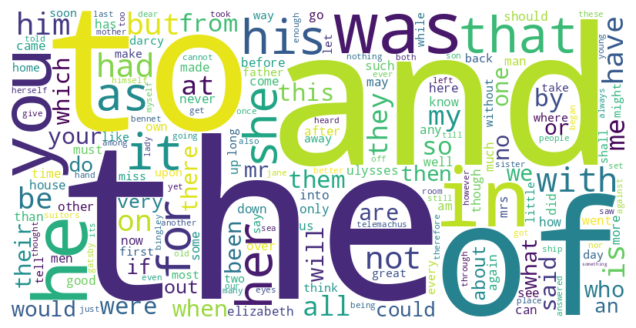

In [137]:
all_words_simple_tokens = list(chain.from_iterable(books_df["simple_tokens"]))
unique_words = list(set(all_words_simple_tokens))
print("NUMBER OF UNIQUE TOKENS:", len(unique_words))

word_counter_simple_tokens = Counter(all_words_simple_tokens)
len(word_counter_simple_tokens.keys())

word_counts_simple_tokens = Series(word_counter_simple_tokens.values(), index=word_counter_simple_tokens.keys())
word_counts_simple_tokens.sort_values(ascending=False).head()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts_simple_tokens)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

NUMBER OF UNIQUE TOKENS: 11020


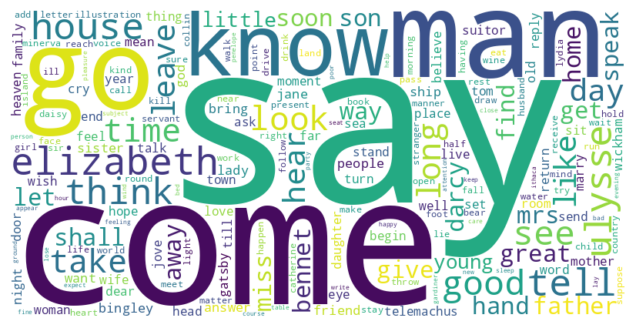

In [138]:
all_words_spacy_tokens = list(chain.from_iterable(books_df["spacy_tokens"]))
unique_words_spacy_tokens = list(set(all_words_spacy_tokens	))
print("NUMBER OF UNIQUE TOKENS:", len(unique_words_spacy_tokens))

word_counter_spacy_tokens = Counter(all_words_spacy_tokens)
len(word_counter_spacy_tokens.keys())

word_counts_spacy_tokens = Series(word_counter_spacy_tokens.values(), index=word_counter_spacy_tokens.keys())
word_counts_spacy_tokens.sort_values(ascending=False).head()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts_spacy_tokens)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

NUMBER OF UNIQUE TOKENS: 8797


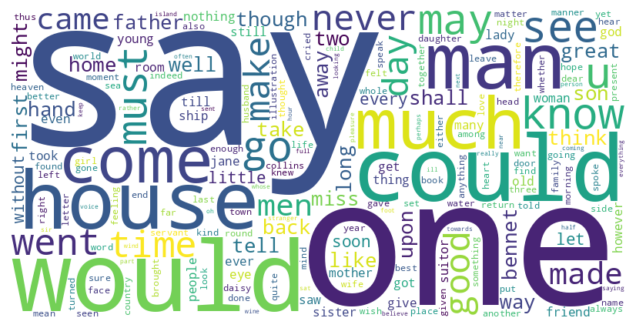

In [139]:
all_words_nltk_tokens = list(chain.from_iterable(books_df["nltk_tokens"]))
unique_words_nltk_tokens = list(set(all_words_nltk_tokens))
print("NUMBER OF UNIQUE TOKENS:", len(unique_words_nltk_tokens))

word_counter_nltk_tokens = Counter(all_words_nltk_tokens)
len(word_counter_nltk_tokens.keys())

word_counts_nltk_tokens = Series(word_counter_nltk_tokens.values(), index=word_counter_nltk_tokens.keys())
word_counts_nltk_tokens.sort_values(ascending=False).head()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts_nltk_tokens)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Corpus of Sentences

So far in our books dataframe, we only have three rows. We have a row per book, with each row containing the entire book text.

This may not work the best for our usual machine learning approach. For example, how would we train test split? We need to have certain parts of each book to use in our training set, and other parts from each book in the test set.

So, let's split each book into sentences, so our new corpus will have a row per sentence, with a label of which book it came from. We can use this sentence-based corpus moving forward.

In [140]:
records = []

for index, row in books_df.iterrows():
    book_name = row["book_name"]
    clean_text = row["book_text"]

    sentences = nltk.sent_tokenize(clean_text)
    for i, sentence in enumerate(sentences):
        records.append({"book_name": book_name, "sentence_id": i, "sentence": sentence})

sentences_df = DataFrame(records)
sentences_df

,book_name,sentence_id,sentence
0,Pride_and_Prejudice,0,b' [Illustration: GEORGE ALLEN PUBLISHER 156 C...
1,Pride_and_Prejudice,1,"and PREJUDICE by Jane Austen, with a Preface b..."
2,Pride_and_Prejudice,2,Charing House.
3,Pride_and_Prejudice,3,Cross Road.
4,Pride_and_Prejudice,4,London George Allen.
...,...,...,...
13954,Great_Gatsby,3398,"And as I sat there brooding on the old, unknow..."
13955,Great_Gatsby,3399,"He had come a long way to this blue lawn, and ..."
13956,Great_Gatsby,3400,He did not know that it was already behind him...
13957,Great_Gatsby,3401,"Gatsby believed in the green light, the orgast..."


In [141]:
sentences_df["book_name"].value_counts()

Pride_and_Prejudice    6093
The_Odyssey            4463
Great_Gatsby           3403
Name: book_name, dtype: int64

## Part I - Benchmark Model

### X/Y Split [Task 3]

Split the corpus of sentences (i.e. the `sentences_df`) into x and y datasets. Choose the book name as the target, and the column of sentence text as the features.

In [142]:
x = sentences_df['sentence']
y = sentences_df['book_name']

### Vectorization [Task 4]

Use TF-IDF vectorizor from sklearn to transform the corpus of sentences (x) into a document term matrix.

When storing the TF-IDF object instance in a variable, specifically name it `vectorizer` (so provided code in Task 9 code will work).


In [189]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vectorizer = TfidfVectorizer()
x_vectorize = vectorizer.fit_transform(x)
x_dense = x_vectorize.toarray()
x_df = pd.DataFrame(x_dense, columns=vectorizer.get_feature_names_out())

In [190]:
x_df.head()

,00,000,10,100,1000,101,102,103,104,105,...,youth,youthis,youths,youve,youwhy,yukon,zacynthus,zelda,zethus,zeus
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train Test Split [Task 5]

Split the data into test and train sets, using the train test split function from sklearn. Remember to use a random seed for reproducibility.

In [191]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_df, y, test_size=0.2, random_state=411)
print("TRAIN:", x_train.shape, y_train.shape)
print("TEST:", x_test.shape, y_test.shape)

TRAIN: (11167, 14734) (11167,)
TEST: (2792, 14734) (2792,)


### Model Training [Task 6]

Train a Logistic Regression model from sklearn on the training data.

When storing the Logistic Regression object instance in a variable, specifically name it `model` (so provided code in Task 9 code will work).

In [192]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=411)
model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(random_state=411)

### Model Explainability [Task 7]

Inspect the model's learned weights (i.e. the coefficients).

For each book, what terms are most predictive / related to that book? For each book, print the names and weights of the "top ten" features (i.e. those having the hightest positive weights).

In [193]:
model.coef_.shape

(3, 14734)

In [194]:
from pandas import DataFrame

coefs = DataFrame(model.coef_, columns=x_df.columns, index=model.classes_).T
coefs.head()

,Great_Gatsby,Pride_and_Prejudice,The_Odyssey
00,0.558585,-0.310778,-0.247806
000,-0.063970,-0.029909,0.093880
10,-0.181681,-0.097772,0.279454
100,-0.067388,-0.085728,0.153116
1000,-0.033816,-0.201066,0.234882


In [195]:
for i in y.unique():
    print("Top 10 for", i)
    print(coefs[i].sort_values(ascending=False).head(10))
    print("---------------------------------------")

Top 10 for Pride_and_Prejudice
elizabeth    4.953612
darcy        3.621850
jane         3.077617
mr           2.913058
bennet       2.903809
not          2.713029
bingley      2.671915
mrs          2.624229
lizzy        2.575259
lydia        2.497632
Name: Pride_and_Prejudice, dtype: float64
---------------------------------------
Top 10 for The_Odyssey
ulysses       5.505136
telemachus    3.719304
suitors       3.124165
and           2.998013
son           2.850734
jove          2.685057
il            2.658393
gods          2.646830
thus          2.543659
ship          2.541860
Name: The_Odyssey, dtype: float64
---------------------------------------
Top 10 for Great_Gatsby
gatsby     3.940737
daisy      3.428153
tom        3.152122
didnt      2.760319
im         2.532930
gatsbys    2.437022
id         2.290727
car        2.283185
dont       2.197398
around     2.042922
Name: Great_Gatsby, dtype: float64
---------------------------------------


### Model Evaluation [Task 8]

A) Use the trained model to make predictions on the test set.

B) Use the predictions to evaluate the model. Specifically display a classification report.

C) Also compute the ROC AUC score, using the predicted probabilities.

D) Finally, display a confusion matrix, as a heatmap.

In [196]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

In [197]:
# Predictions
y_pred = model.predict(x_test)

In [198]:
# ROC Score:
y_pred_proba = model.predict_proba(x_test)
y_pred_proba[0:5]
print("Model ROC Score:",roc_auc_score(y_test, y_pred_proba, multi_class="ovr"))

Model ROC Score: 0.9715726177951928


In [199]:
# classification metrics
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

       Great_Gatsby       0.84      0.80      0.82       695
Pride_and_Prejudice       0.87      0.92      0.90      1240
        The_Odyssey       0.91      0.87      0.89       857

           accuracy                           0.88      2792
          macro avg       0.87      0.86      0.87      2792
       weighted avg       0.88      0.88      0.88      2792



In [200]:
import plotly.express as px

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
# Heatmap
def plot_confusion_matrix(cmat, model, fig_show=True, fig_save=False, showscale=False):

    title = f"Confusion Matrix ({model.__class__.__name__})"

    # Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.
    # ROW: TRUE | COLUmN: PRED
    fig = px.imshow(cmat, x=model.classes_, y=model.classes_, height=650,
                    labels={"x": "Predicted", "y": "Actual"},
                    color_continuous_scale="Blues", text_auto=True,
    )
    fig.update_layout(title={'text': title, 'x':0.485, 'xanchor': 'center'})
    fig.update_coloraxes(showscale=showscale) # consider removing the color scale from the image

    if fig_show:
        fig.show()

    if fig_save:
        fig.write_image("confusion.png")
        fig.write_html("confusion.html")


plot_confusion_matrix(conf_matrix, model)

Confusion Matrix:
[[ 557  106   32]
 [  59 1142   39]
 [  51   60  746]]


### Inference [Task 9]

Create your own example sentences that might use similar language as each of the books you have chosen.

Use the trained model to predict which book most closely resembles the language used in each of the new sentences.

See example below, but use your own sentences corresponding with the books you have chosen. Feel free to add more sentences and revise as desired

In [34]:
new_sentences = [
    "Amidst the opulent soirée at Gatsby's mansion, the air was thick with the ineffable allure of unrestrained extravagance, encapsulating the essence of a bygone era.",
    "In the opulent glow of Gatsby's soirées, the revelers danced to the rhythm of a Jazz Age symphony, their dreams reflected in the shimmering lights of decadence",
    "Behind the façade of wealth and excess, the enigmatic millionaire yearned for a past that lingered like a haunting melody, lost in the ceaseless whirlwind of the Roaring Twenties.",
    "As the assembly at the Meryton ball unfolded, Mr. Darcy's enigmatic presence cast a shadow over the proceedings, stirring whispers of curiosity and sparking a delicate dance of social intricacies among the assembled guests.",
    "Amidst the refined ballrooms of Hertfordshire, the dance of manners unfolded, intertwining the destinies of Elizabeth Bennet and Mr. Darcy in the delicate waltz of social expectations and unspoken affections.",
    "Beneath the veil of polite society, the subtle interplay of wit and decorum masked a landscape where hearts dared to defy the rigid constraints of pride and prejudice.",
    "Amidst the tumultuous waves and distant echoes of mythic shores, the weary traveler sought solace in the enigmatic embrace of uncharted realms, where destiny unfolded like the pages of a forgotten epic.",
    "Through the labyrinth of time, the wanderer encountered celestial whispers, unraveling tales woven into the cosmic tapestry of existence.",
    "Guided by an invisible hand, the sojourner navigated treacherous realms, forging a saga that mirrored the eternal dance between mortal yearning and the cosmic orchestrations of fate.",
]
new_sentences_x = vectorizer.transform(new_sentences)
predictions = model.predict(new_sentences_x)
print("Predictions:", predictions)

Predictions: ['Great_Gatsby' 'Great_Gatsby' 'Great_Gatsby' 'Pride_and_Prejudice'
 'Pride_and_Prejudice' 'Pride_and_Prejudice' 'Great_Gatsby' 'Great_Gatsby'
 'Great_Gatsby']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



In [35]:
from pandas import Series

preds_df = Series(predictions, index=new_sentences)
preds_df

Amidst the opulent soirée at Gatsby's mansion, the air was thick with the ineffable allure of unrestrained extravagance, encapsulating the essence of a bygone era.                                                                       Great_Gatsby
In the opulent glow of Gatsby's soirées, the revelers danced to the rhythm of a Jazz Age symphony, their dreams reflected in the shimmering lights of decadence                                                                           Great_Gatsby
Behind the façade of wealth and excess, the enigmatic millionaire yearned for a past that lingered like a haunting melody, lost in the ceaseless whirlwind of the Roaring Twenties.                                                       Great_Gatsby
As the assembly at the Meryton ball unfolded, Mr. Darcy's enigmatic presence cast a shadow over the proceedings, stirring whispers of curiosity and sparking a delicate dance of social intricacies among the assembled guests.    Pride_and_Prejudice
Amidst the r

## Part II - Best Model [Task 10]


Use a grid search from sklearn, in conjunction with a pipeline from sklearn, to find the combination of vectorizer and model parameters that yield the best classification results.

Explore at least two different classifier models (e.g. Logistic Regression and Naive Bayes), performing a separate grid search for each.

For each:

  + Setup a pipeline containing a TF-IDF vectorizer, as well as the chosen model.

  + For the TF-IDF parameter grid, explore using different vectorization parameters, including different tokenization functions and stopword removal strategies, etc.

  + For the model's parameter grid, because different models use different parameters, your parameter grid will need to reflect the parameters of the chosen model.

  + Setup a grid search using the pipeline and the parameter grid. Use five fold cross validation. And choose "auc_roc_ovr" as the scoring metric to optimize on.

  + After training the grid search, print the best parameters that it found. Also conduct a formal evaluation including classification report and confusion matrix (similar to Task 8).


Finally, summarize your results in a text cell at the bottom, and answer the questions posed there.


### Best Logistic Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [211]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import label_binarize

In [113]:
# Define the pipeline for Logistic Regression
lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# Define the parameter grid for Logistic Regression
lr_param_grid = {
    'tfidf__max_features': [1000, 5000, 10000],
    'tfidf__stop_words': [None, 'english'],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__solver': ['liblinear'],
}
def custom_roc_auc_score(estimator, X, y):
    try:
        y_score = estimator.predict_proba(X)
        return roc_auc_score(y, y_score, multi_class='ovr')
    except ValueError as e:
        print(f"Error in custom_roc_auc_score: {e}")
        return np.nan

In [114]:
# Create a label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Train Test Split
x_train_lr, x_test_lr, y_train_lr, y_test_lr = train_test_split(x, y_encoded, test_size=0.2, random_state=411)
print("TRAIN:", x_train_lr.shape, y_train_lr.shape)
print("TEST:", x_test_lr.shape, y_test_lr.shape)

TRAIN: (11167,) (11167,)
TEST: (2792,) (2792,)


In [115]:
lr_grid_search = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, scoring=custom_roc_auc_score)
lr_grid_search.fit(x_train_lr, y_train_lr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', LogisticRegression())]),
             param_grid={'clf__C': [0.1, 1.0, 10.0],
                         'clf__solver': ['liblinear'],
                         'tfidf__max_features': [1000, 5000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__stop_words': [None, 'english']},
             scoring=<function custom_roc_auc_score at 0x7dde7009d5a0>)

In [116]:
# Print best parameters and evaluate the model
print("Best Parameters for Logistic Regreesion:")
print(lr_grid_search.best_params_)

Best Parameters for Logistic Regreesion:
{'clf__C': 10.0, 'clf__solver': 'liblinear', 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}


In [210]:
# Model Informaiton
print(lr_grid_search.best_estimator_)
print(lr_grid_search.best_estimator_.named_steps)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('clf', LogisticRegression(C=10.0, solver='liblinear'))])
{'tfidf': TfidfVectorizer(max_features=10000, ngram_range=(1, 2)), 'clf': LogisticRegression(C=10.0, solver='liblinear')}


In [203]:
# evaluate the model
lr_y_pred = lr_grid_search.predict(x_test_lr)
print("\nClassification Report for Naive Bayes:")
print(classification_report(y_test_lr, lr_y_pred))
print("\nConfusion Matrix for Naive Bayes:")
print(confusion_matrix(y_test_lr, lr_y_pred))
plot_confusion_matrix(confusion_matrix(y_test_lr, lr_y_pred), lr_grid_search)


Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       695
           1       0.90      0.92      0.91      1240
           2       0.91      0.90      0.90       857

    accuracy                           0.89      2792
   macro avg       0.89      0.88      0.89      2792
weighted avg       0.89      0.89      0.89      2792


Confusion Matrix for Naive Bayes:
[[ 580   83   32]
 [  55 1140   45]
 [  40   47  770]]


In [213]:
# ROC Score
y_true_one_hot = label_binarize(y_test_lr, classes=lr_grid_search.classes_)
y_pred_one_hot = label_binarize(lr_y_pred, classes=lr_grid_search.classes_)
roc_auc = roc_auc_score(y_true_one_hot, y_pred_one_hot, multi_class='ovr')

print("ROC AUC Score for Naive Bayes:", roc_auc)

ROC AUC Score for Naive Bayes: 0.9139185519214955


### Best Naive Bayes

http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [118]:
from sklearn.naive_bayes import MultinomialNB

In [119]:
# Define the pipeline for Naive Bayes
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])
# Define the parameter grid for Naive Bayes
nb_param_grid = {
    'tfidf__max_features': [1000, 5000, 10000],
    'tfidf__stop_words': [None, 'english'],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.1, 0.5, 1.0],
}


In [120]:
x_train_nb, x_test_nb, y_train_nb, y_test_nb = train_test_split(x, y, test_size=0.2, random_state=411)
print("TRAIN:", x_train_nb.shape, y_train_nb.shape)
print("TEST:", x_test_nb.shape, y_test_nb.shape)

TRAIN: (11167,) (11167,)
TEST: (2792,) (2792,)


In [121]:
nb_grid_search = GridSearchCV(nb_pipeline, nb_param_grid, cv=5, scoring=custom_roc_auc_score)
nb_grid_search.fit(x_train_nb, y_train_nb)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': [0.1, 0.5, 1.0],
                         'tfidf__max_features': [1000, 5000, 10000],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__stop_words': [None, 'english']},
             scoring=<function custom_roc_auc_score at 0x7dde7009d5a0>)

In [122]:
# Print best parameters and evaluate the model
print("Best Parameters for Naive Bayes:")
print(nb_grid_search.best_params_)

Best Parameters for Naive Bayes:
{'clf__alpha': 0.1, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}


In [208]:
# Model Informaiton
print(nb_grid_search.best_estimator_)
print(nb_grid_search.best_estimator_.named_steps)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=10000)),
                ('clf', MultinomialNB(alpha=0.1))])
{'tfidf': TfidfVectorizer(max_features=10000), 'clf': MultinomialNB(alpha=0.1)}


In [125]:
# evaluate the model
nb_y_pred = nb_grid_search.predict(x_test_nb)
print("\nClassification Report for Naive Bayes:")
print(classification_report(y_test_nb, nb_y_pred))
print("\nConfusion Matrix for Naive Bayes:")
print(confusion_matrix(y_test_nb, nb_y_pred))
plot_confusion_matrix(confusion_matrix(y_test_nb, nb_y_pred), nb_grid_search)


Classification Report for Naive Bayes:
                     precision    recall  f1-score   support

       Great_Gatsby       0.95      0.74      0.83       695
Pride_and_Prejudice       0.86      0.96      0.91      1240
        The_Odyssey       0.90      0.92      0.91       857

           accuracy                           0.89      2792
          macro avg       0.90      0.87      0.88      2792
       weighted avg       0.90      0.89      0.89      2792


Confusion Matrix for Naive Bayes:
[[ 511  129   55]
 [  19 1190   31]
 [   9   59  789]]


In [212]:
# ROC Score
y_true_one_hot = label_binarize(y_test_nb, classes=nb_grid_search.classes_)
y_pred_one_hot = label_binarize(nb_y_pred, classes=nb_grid_search.classes_)
roc_auc = roc_auc_score(y_true_one_hot, y_pred_one_hot, multi_class='ovr')

print("ROC AUC Score for Naive Bayes:", roc_auc)

ROC AUC Score for Naive Bayes: 0.9061086311485281


### Results Summary

Benchmark Model Performance:
  + ACCY: 0.88
  + ROC AUC: 0.9715726177951928


Best Logistic Regression Model Performance:
  + ACCY: 0.89
  + ROC AUC: 0.9139185519214955
  + Vectorization params: The standard TfidfVectorizer
  + Model params: {'clf__C': 10.0, 'clf__solver': 'liblinear', 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}


Best Naive Bayes Model Performance:
  + ACCY: 0.89
  + ROC AUC: 0.9061086311485281
  + Vectorization params: The standard TfidfVectorizer
  + Model params: {'clf__alpha': 0.1, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}






Which model / grid search performs the best? What are its parameters? FYI: we can use the grid search object's `best_estimator_` and `named_steps` properties to access the parameters for the model and the vectorizer, respectively).

Answer: The best model for this case is the Best Logistic Regression Model with an accuracy score of .89 and an roc score of 0.9139185519214955. The models best estimators and named steps are:
Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
                ('clf', LogisticRegression(C=10.0, solver='liblinear'))])
{'tfidf': TfidfVectorizer(max_features=10000, ngram_range=(1, 2)), 'clf': LogisticRegression(C=10.0, solver='liblinear')}.

How does your best model compare with the initial benchmark from Part I?

Answer: There is an improvement in the model from 0.88 to 0.89 for their accuracy score.

What parameter or methodology changes had the greatest impact on improving model performance?

Answer: By keeping the standard TfidfVectorizer the accuracy score rose any where from 3% when compared to spacy vectorizer and 5% when using the NLTK vectorizer to tokenize the data.


